In [1]:
import tkinter as tk
import os
from tkinter import ttk
from tkinter import *
from PIL import Image, ImageTk
from tkinter import ttk, messagebox
from datetime import datetime
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg


In [2]:
# Función para entrenar el modelo de regresión polinomial de segundo grado multiple
def entrenar_modelos(path_csv):
    df = pd.read_csv(path_csv)
    
    
    # Se crea una columna en el dataset llamada "ruta", que estará compuesta por el origen y el destino
    df['ruta'] = df['Source'] + '-' + df['Destination']

    modelos_por_ruta = {}
    transformadores_por_ruta = {}

    # Definimos las variables cualitativas como dummy features para que el modelo pueda procesarlas
    dummy_columns = ['Airline_AirAsia', 'Airline_IndiGo', 'Airline_SpiceJet', 'Airline_Vistara', 'Airline_GoAir', 'Airline_Jet Airways', 'Airline_Multiple carriers']

    for ruta in df['ruta'].unique():
        df_ruta = df[df['ruta'] == ruta].copy()
        df_encoded = pd.get_dummies(df_ruta, columns=['Airline'])

        # Comprobación de que todas las columnas dummy estén presentes
        for col in dummy_columns:
            if col not in df_encoded:
                df_encoded[col] = 0

        try:
            # Entrenamiento del modelo con las variables independientes cuantitativas y las variables dummy que representan a las cualitativas
            X = df_encoded[['Month', 'Dep_hours'] + dummy_columns]
            y = df_encoded['Price']

            # Determinación del modelo polinomial de segundo grado para las variables
            poly = PolynomialFeatures(degree=2, include_bias=False)
            X_poly = poly.fit_transform(X)

            # Se dividen los datos para tener un 80% en el entrenamiento y un 20% en la prueba
            X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
            model = LinearRegression()
            model.fit(X_train, y_train)

            modelos_por_ruta[ruta] = model
            transformadores_por_ruta[ruta] = poly
        except:
            continue

    return modelos_por_ruta, transformadores_por_ruta


# Función para predecir el precio dado una ruta, mes, hora y aerolínea
def predecir_precio(ruta, mes, dep_hour, aerolinea, modelos_por_ruta, transformadores_por_ruta):
    if ruta not in modelos_por_ruta:
        return None

    # Creación del diccionario donde se almacena el input del usuario
    dummy_features = {
        'Month': mes,
        'Dep_hours': dep_hour,
        'Airline_AirAsia': 1 if aerolinea == 'AirAsia' else 0,
        'Airline_IndiGo': 1 if aerolinea == 'IndiGo' else 0,
        'Airline_SpiceJet': 1 if aerolinea == 'SpiceJet' else 0,
        'Airline_Vistara': 1 if aerolinea == 'Vistara' else 0,
        'Airline_GoAir': 1 if aerolinea == 'GoAir' else 0,
        'Airline_Jet Airways': 1 if aerolinea == 'Jet Airways' else 0,
        'Airline_Multiple carriers': 1 if aerolinea == 'Multiple carriers' else 0
    }

    # Conversión del diccionario 
    entrada = pd.DataFrame([dummy_features])
    
    # Obtención de los transformadores polinomiales y el modelo a usar en la ruta escogida 
    poly = transformadores_por_ruta[ruta]
    modelo = modelos_por_ruta[ruta]
    
    # Se transforman el input para ajustarse al modelo polinomial, se predice el precio y se retorna redondeado a 2 decimales
    entrada_poly = poly.transform(entrada)
    precio = modelo.predict(entrada_poly)[0]
    return round(precio, 2)


In [3]:
modelos_por_ruta, transformadores_por_ruta = entrenar_modelos("flight_dataset.csv")

In [4]:
#========= Interfaz =========
ventana = Tk()
ventana.title("Proyecto final")

# Tamaño de la ventana
ancho_ventana = 1200
alto_ventana = 1000

# Obtener dimensiones de la pantalla
ancho_pantalla = ventana.winfo_screenwidth()
alto_pantalla = ventana.winfo_screenheight()

# Calcular coordenadas x, y para centrar la ventana
x = (ancho_pantalla // 2) - (ancho_ventana // 2)
y = (alto_pantalla // 2) - (alto_ventana // 2)

# Establecer geometría centrada
ventana.geometry(f"{ancho_ventana}x{alto_ventana}+{x}+{y}")

# Fondo 
img = Image.open("images/fondo.png").resize((1200, 1000))
fondo = ImageTk.PhotoImage(img)
x = tk.Label(ventana, image=fondo)
x.image = fondo
x.place(x=0, y=0, relwidth=1, relheight=1)

# Nombre del proyecto Shark Tank 
titulo = tk.Label(
    ventana,
    text="Happy Route",
    font=("Arial", 48),   
    fg="gray",                  
    bg="white"                 
)
titulo.place(x=440, y=235) 

# Titulo 
titulo = tk.Label(
    ventana,
    text="Flights Calculator",
    font=("Arial", 40),   
    fg="white",                  
    bg="purple"                 
)
titulo.place(x=440, y=350)   

In [5]:
def abrir_personalizado():
    ventana.withdraw()

    c = tk.Toplevel()
    c.title("Predicción Personalizada")

    ancho_ventana = 1200
    alto_ventana = 1000
    ancho_pantalla = c.winfo_screenwidth()
    alto_pantalla = c.winfo_screenheight()
    x = (ancho_pantalla // 2) - (ancho_ventana // 2)
    y = (alto_pantalla // 2) - (alto_ventana // 2)
    c.geometry(f"{ancho_ventana}x{alto_ventana}+{x}+{y}")

    # Fondo
    img1 = Image.open("images/interfaz.png").resize((1200, 1000))
    fondo1 = ImageTk.PhotoImage(img1)
    fondo_label = tk.Label(c, image=fondo1)
    fondo_label.image = fondo1
    fondo_label.place(x=0, y=0, relwidth=1, relheight=1)

    # Estilos
    estilo_label = {"font": ("Arial", 18), "bg": "#4B0082", "fg": "white"}
    estilo_button = {"font": ("Arial", 14), "bg": "#00008B", "fg": "white", "activebackground": "#1E90FF"}

    # Widgets individualmente centrados
    tk.Label(c, text="Rutas disponibles:", **estilo_label).place(relx=0.5, rely=0.15, anchor="center")
    rutas = list(modelos_por_ruta.keys())
    ruta_var = tk.StringVar()
    ruta_cb = ttk.Combobox(c, textvariable=ruta_var, values=rutas, state="readonly", font=("Arial", 14), width=30)
    ruta_cb.place(relx=0.5, rely=0.20, anchor="center")
    ruta_cb.current(0)

    tk.Label(c, text="Mes del vuelo (3-6):", **estilo_label).place(relx=0.5, rely=0.28, anchor="center")
    meses = [str(m) for m in range(3, 7)]
    mes_var = tk.StringVar()
    mes_cb = ttk.Combobox(c, textvariable=mes_var, values=meses, state="readonly", font=("Arial", 14), width=10)
    mes_cb.place(relx=0.5, rely=0.33, anchor="center")
    mes_cb.current(0)

    tk.Label(c, text="Hora de salida (0-23):", **estilo_label).place(relx=0.5, rely=0.41, anchor="center")
    horas = [str(h) for h in range(0, 24)]
    hora_var = tk.StringVar()
    hora_cb = ttk.Combobox(c, textvariable=hora_var, values=horas, state="readonly", font=("Arial", 14), width=10)
    hora_cb.place(relx=0.5, rely=0.46, anchor="center")
    hora_cb.current(12)

    tk.Label(c, text="Selecciona una aerolínea:", **estilo_label).place(relx=0.5, rely=0.54, anchor="center")
    aerolineas = [
        "IndiGo", "AirAsia", "Vistara", "SpiceJet",
        "GoAir", "Jet Airways", "Multiple carriers"
    ]
    
    aerolinea_var = tk.StringVar()
    aerolinea_cb = ttk.Combobox(c, textvariable=aerolinea_var, values=aerolineas, state="readonly", font=("Arial", 14), width=25)
    aerolinea_cb.place(relx=0.5, rely=0.59, anchor="center")
    aerolinea_cb.current(0)

    # Función de predicción
    def predecir():
        ruta = ruta_var.get()
        mes = int(mes_var.get())
        hora = int(hora_var.get())
        aerolinea = aerolinea_var.get()

        precio = predecir_precio(
            ruta, mes, hora, aerolinea,
            modelos_por_ruta, transformadores_por_ruta
        )

        if precio is not None:
            messagebox.showinfo("Predicción", f"Precio estimado para {ruta}: ${precio}")
        else:
            messagebox.showerror("Error", "No se encontró modelo para la ruta seleccionada.")

    # Botones centrados
    tk.Button(c, text="Predecir", command=predecir, **estilo_button).place(relx=0.5, rely=0.70, anchor="center")
    tk.Button(c, text="Cerrar", command=lambda: [c.destroy(), ventana.deiconify()], **estilo_button).place(relx=0.5, rely=0.77, anchor="center")


In [6]:
def abrir_prediccion_simple():
    ventana.withdraw()

    # Crear ventana secundaria
    c = tk.Toplevel()
    c.title("Predicción rápida")

    ancho_ventana = 1200
    alto_ventana = 1000
    ancho_pantalla = c.winfo_screenwidth()
    alto_pantalla = c.winfo_screenheight()
    x = (ancho_pantalla // 2) - (ancho_ventana // 2)
    y = (alto_pantalla // 2) - (alto_ventana // 2)
    c.geometry(f"{ancho_ventana}x{alto_ventana}+{x}+{y}")

    # Fondo 
    img1 = Image.open("images/interfaz.png").resize((1200, 1000))
    fondo1 = ImageTk.PhotoImage(img1)
    fondo_label = tk.Label(c, image=fondo1)
    fondo_label.image = fondo1
    fondo_label.place(x=0, y=0, relwidth=1, relheight=1)

    # Estilo común 
    estilo_label = {"font": ("Arial", 18), "bg": "#4B0082", "fg": "white"}
    estilo_button = {"font": ("Arial", 14), "bg": "#00008B", "fg": "white", "activebackground": "#1E90FF"}

    # Widgets centrados individualmente 
    tk.Label(c, text="Selecciona una ruta:", **estilo_label).place(relx=0.5, rely=0.25, anchor="center")
    rutas = list(modelos_por_ruta.keys())
    ruta_var = tk.StringVar()
    ruta_cb = ttk.Combobox(c, textvariable=ruta_var, values=rutas, state="readonly", font=("Arial", 14), width=30)
    ruta_cb.place(relx=0.5, rely=0.30, anchor="center")
    ruta_cb.current(0)

    # Función de predicción 
    def predecir_rapido():
        ruta = ruta_var.get()
        mes = 4
        hora = 12
        aerolinea = "IndiGo"

        precio = predecir_precio(
            ruta, mes, hora, aerolinea,
            modelos_por_ruta, transformadores_por_ruta
        )

        if precio is not None:
            messagebox.showinfo("Predicción rápida", f"Precio estimado para {ruta}: ${precio}")
        else:
            messagebox.showerror("Error", "No se encontró modelo para la ruta seleccionada.")

    # Botones centrados 
    tk.Button(c, text="Predecir automáticamente", command=predecir_rapido, **estilo_button).place(relx=0.5, rely=0.42, anchor="center")
    tk.Button(c, text="Cerrar", command=lambda: [c.destroy(), ventana.deiconify()], **estilo_button).place(relx=0.5, rely=0.50, anchor="center")


In [7]:
def mostrar_csv():
    ventana_csv = tk.Toplevel()
    ventana_csv.configure(bg="#e0f7fa")  # Fondo azul claro
    ventana_csv.title("Datos de vuelos disponibles")
    ventana_csv.geometry("1000x600")

    # Título con color
    titulo = tk.Label(
        ventana_csv, text="Dataset de vuelos", 
        font=("Arial", 20), 
        bg="#00008B", fg="white", 
        padx=10, pady=10
    )
    titulo.pack(pady=10)

    # Frame con color
    frame_tabla = tk.Frame(ventana_csv, bg="#b3e5fc", bd=2, relief="ridge")
    frame_tabla.pack(fill="both", expand=True, padx=10, pady=10)

    # Cargar datos
    df = pd.read_csv("flight_dataset.csv")

    # Tabla
    tabla = ttk.Treeview(frame_tabla, columns=list(df.columns), show="headings")

    for col in df.columns:
        tabla.heading(col, text=col)
        tabla.column(col, anchor="center", width=150)

    for _, row in df.iterrows():
        tabla.insert("", "end", values=list(row))

    tabla.pack(side="left", fill="both", expand=True)

    # Scrollbars
    scroll_y = ttk.Scrollbar(frame_tabla, orient="vertical", command=tabla.yview)
    scroll_x = ttk.Scrollbar(ventana_csv, orient="horizontal", command=tabla.xview)

    tabla.configure(yscrollcommand=scroll_y.set, xscrollcommand=scroll_x.set)

    scroll_y.pack(side="right", fill="y")
    scroll_x.pack(side="bottom", fill="x")

    # Botón cerrar con color
    cerrar = tk.Button(
        ventana_csv, text="Cerrar", command=ventana_csv.destroy,
        bg="#00008B", fg="white", font=("Arial", 12), padx=15, pady=5
    )
    cerrar.pack(pady=10)



In [8]:
# Se extraen las rutas que hay en el dataset para usarlas en la interfaz gráfica

df = pd.read_csv("flight_dataset.csv") 
df["Ruta"] = df["Source"] + "-" + df["Destination"]  
rutas_unicas = sorted(df["Ruta"].unique())

In [9]:
# Creamos un ejemplo de estilo para poder personalizar la interfaz
estilo = ttk.Style()
estilo.theme_use("clam") 

estilo.configure("TCombobox",
    fieldbackground="white",
    background="lightgrey",
    foreground="black",
    padding=5
)

# Creamos una variable StringVar para almacenar la ruta que el usuario sleccione
ruta_var = tk.StringVar()
combo_rutas = ttk.Combobox(
    ventana, 
    textvariable=ruta_var, 
    values=rutas_unicas, 
    font=("Arial", 12),
    state="readonly",
    width=30
)
combo_rutas.set("Selecciona una ruta")
combo_rutas.place(x=500, y=717)  


In [10]:
def ver_grafica():
    ruta = ruta_var.get()
    
    # Se verifica que la ruta se encuentre dentro de las listadas
    if ruta not in rutas_unicas:
        messagebox.showwarning("Ruta no válida", "Selecciona una ruta de la lista.")
        return

    df_ruta = df[df["Ruta"] == ruta].copy()

    # Se verifica que existan registros de esa ruta. Por la lógica del programa, este caso nunca sucede pues las rutas se crean leyendo el dataset,
    # pero se decidió añadir la verificación de todas maneras
    if df_ruta.empty:
        messagebox.showinfo("Sin datos", f"No hay datos disponibles para la ruta {ruta}")
        return
    
    # Se verifica que existan registros de al menos más de un mes y de más de una hora de abordaje, esto para que sea posible graficar en 3D
    if df_ruta["Month"].nunique() < 2 or df_ruta["Dep_hours"].nunique() < 2:
        messagebox.showwarning("Datos insuficientes", f"La ruta '{ruta}' no tiene suficiente datos para graficar en 3D.")
        return

    # Asegurarse de tener valores numéricos
    df_ruta = df_ruta.dropna(subset=["Month", "Dep_hours", "Price"])

    # Entrenar modelo polinomial de 2° grado
    X = df_ruta[["Month", "Dep_hours"]].values
    y = df_ruta["Price"].values

    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)

    modelo = LinearRegression()
    modelo.fit(X_poly, y)

    # Crear ventana nueva
    ventana_3d = tk.Toplevel()
    ventana_3d.title(f"Regresión 3D para {ruta}")
    ventana_3d.geometry("900x700")

    # Crear malla de predicción
    x_range = np.linspace(X[:,0].min(), X[:,0].max(), 40)
    y_range = np.linspace(X[:,1].min(), X[:,1].max(), 40)
    x_surf, y_surf = np.meshgrid(x_range, y_range)
    X_pred = np.column_stack((x_surf.ravel(), y_surf.ravel()))
    z_pred = modelo.predict(poly.transform(X_pred)).reshape(x_surf.shape)

    # Graficar
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x_surf, y_surf, z_pred, cmap="viridis", alpha=0.9)
    ax.set_xlabel("Mes")
    ax.set_ylabel("Hora de Salida")
    ax.set_zlabel("Precio estimado")
    ax.set_title(f"Regresión 3D para {ruta}")

    # Mostrar en Tkinter
    canvas = FigureCanvasTkAgg(fig, master=ventana_3d)
    canvas.draw()
    canvas.get_tk_widget().pack()


In [11]:
#======== Botones =========
op1 = tk.Button(
    ventana, 
    text="Quick calculation", 
    command=abrir_prediccion_simple,
    font=("Arial",18),
    width=20,
    height=2,
    bg="darkblue",
    fg="white"
    )
op1.place(x=500, y=450)

op2 = tk.Button(
    ventana, 
    text="Personalized calculation", 
    command=abrir_personalizado,
    font=("Arial",18),
    width=20,
    height=2,
    bg="darkblue",
    fg="white"
    )
op2.place(x=500, y=550)

op3 = tk.Button(
    ventana,
    text="Ver dataset",
    command=mostrar_csv,
    font=("Arial", 14),
    bg="green",
    fg="white"
)
op3.place(x=590, y=660)

op4 = tk.Button(
    ventana, 
    text="Ver gráfica de tendencia", 
    command=ver_grafica,
    font=("Arial",14),
    bg="green",
    fg="white"
)
op4.place(x=530, y=770)

exit = tk.Button(
    ventana,
    text="exit",
    command=ventana.destroy,
    font=("Arial",14),
    width=20,
    height=2,
    bg="grey",
    fg="black"
)
exit.place(x=530,y=850)

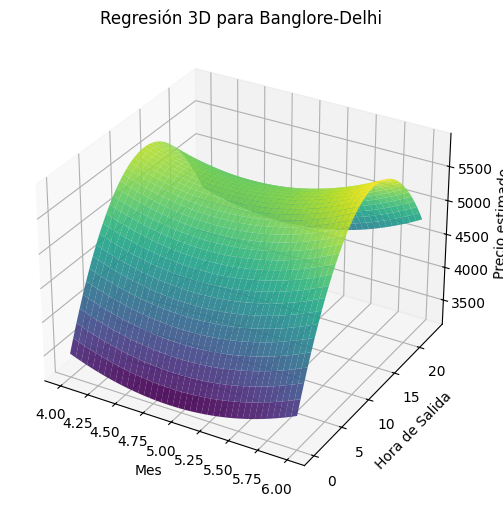

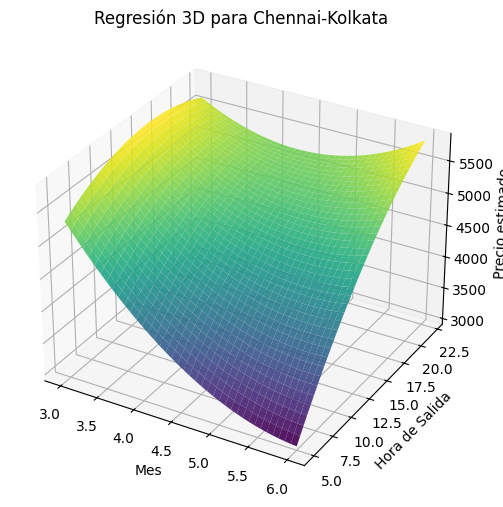

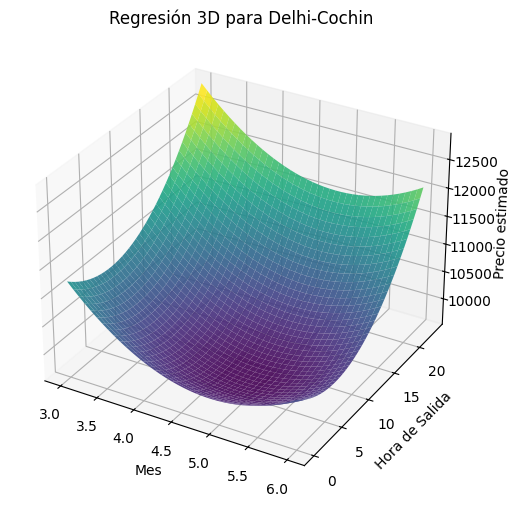

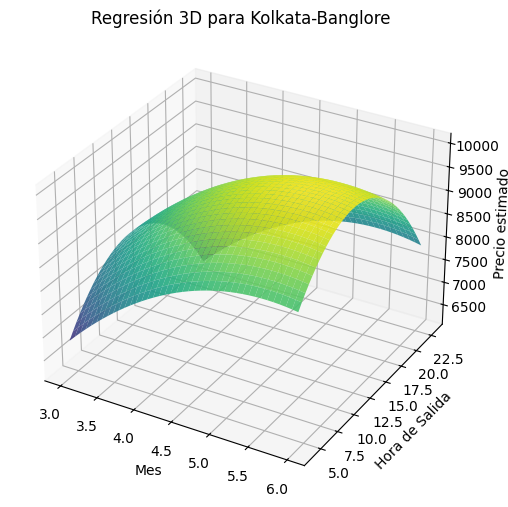

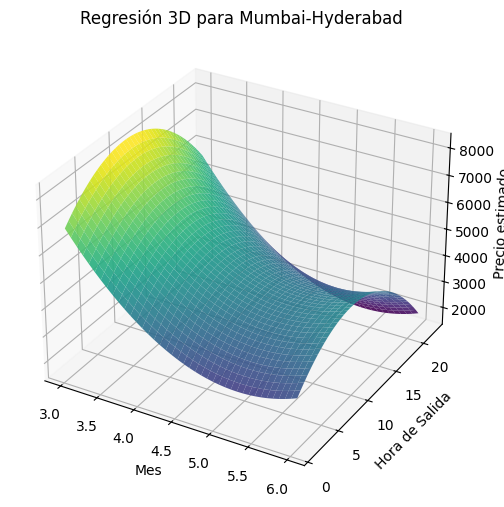

In [12]:

#======== Ejecución =========
ventana.mainloop()
